In [1]:
import random
import json
from dataclasses import dataclass, field
from typing import Optional

import pandas as pd
import numpy as np


from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import (
    EvalPrediction,
    Trainer,
    default_data_collator,
    TrainingArguments,
    HfArgumentParser
)

In [2]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )

@dataclass
class DataArguments:
    fold: int = field()
    k: int = field()
        
training_args = TrainingArguments('/home/nlp/experiments/edit')

In [3]:
with open("edit_data.json", "r") as read_file:
    data = json.load(read_file)

df = pd.DataFrame(data)

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

In [4]:
def preprocess_function(examples):
#     prompt = str(examples['body'])
    prompt = str(examples['headline'])
    choice0, choice1, choice2 = str(examples['thesis']), str(examples['anti-thesis']), str(examples['third-option'])
    choices = [choice0, choice1, choice2]
#     random.shuffle(choices)
    # Specify max_length=512 in encoding when not using body
    encoding = tokenizer([prompt, prompt, prompt], choices, return_tensors='pt', padding='max_length', truncation=True)
#     encoding["label"] = choices.index(choice0)
    encoding["label"] = 0
    return encoding


five_fold = {0: list(range(0, 169)),
             1: list(range(169, 338)),
             2: list(range(338, 507)),
             3: list(range(507, 676)),
             4: list(range(676, 845))}

In [5]:
total_indexes = set(range(0, 845))
valid_indexes = set(five_fold[0])
train_indexes = total_indexes - valid_indexes
train_indexes, valid_indexes = list(train_indexes), list(valid_indexes)
assert len(train_indexes)+len(valid_indexes) <= 845
assert len(train_indexes)+len(valid_indexes) > 840

In [6]:
# train_dataset = Dataset.from_pandas(df.iloc[train_indexes])
eval_dataset = Dataset.from_pandas(df.iloc[valid_indexes])
# train_dataset = train_dataset.map(preprocess_function)
eval_dataset = eval_dataset.map(preprocess_function)

In [7]:
# model = AutoModelForMultipleChoice.from_pretrained('/home/nlp/experiments/edit/lf_body/0', return_dict=True)

In [8]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}


# trainer = Trainer(
#         model=model,
#         args=training_args,
# #         train_dataset=train_dataset,
#         eval_dataset=eval_dataset,
#         compute_metrics=compute_metrics,
#         tokenizer=tokenizer,
#         data_collator=default_data_collator,
# )

In [9]:
predicted_labels = []
gold_labels = []

for i in range(len(five_fold)):
    valid_indexes = list(set(five_fold[i]))
    df = pd.DataFrame(data)
    eval_dataset = Dataset.from_pandas(df.iloc[valid_indexes])
    eval_dataset = eval_dataset.map(preprocess_function)
    model = AutoModelForMultipleChoice.from_pretrained('/home/nlp/experiments/edit/lf_headline/'+str(i), return_dict=True)
    trainer = Trainer(
        model=model,
        args=training_args,
#         train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
    )
    output_vals = trainer.predict(eval_dataset)
#     print(trainer.evaluate())
    val_labels = []
    for j in eval_dataset:
        val_labels.append(j["label"])
        
    gold_labels.extend(val_labels)
    predicted_labels.extend(np.argmax(output_vals.predictions, axis=1))

/home/nlp/.local/lib/python3.8/site-packages/transformers/modeling_longformer.py:71: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  sep_token_indices = (input_ids == sep_token_id).nonzero()
/home/nlp/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt

In [11]:
len(gold_labels), len(predicted_labels)

(845, 845)

In [12]:
categories = {0: 'thesis', 1: 'anti', 2: 'third'}

In [13]:
gold_labels_word, predicted_labels_word = [], []
for i in range(len(gold_labels)):
    gold_labels_word.append(categories[gold_labels[i]])
    predicted_labels_word.append(categories[predicted_labels[i]])

In [14]:
# conf = confusion_matrix(gold_labels_word, predicted_labels_word)

In [15]:
conf = confusion_matrix(gold_labels, predicted_labels)

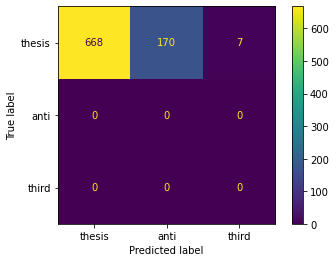

In [16]:
cmd = ConfusionMatrixDisplay(conf, display_labels=['thesis', 'anti', 'third'])
cmd.plot()

In [17]:
cmd.figure_.savefig('headline.pdf')

In [11]:
# tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")
# model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-summarize-news").cuda()

# tokenizer = AutoTokenizer.from_pretrained("google/pegasus-multi_news")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-multi_news").cuda()
# stokenizer = AutoTokenizer.from_pretrained("sentence-transformers/roberta-large-nli-stsb-mean-tokens")
# smodel = AutoModel.from_pretrained("sentence-transformers/roberta-large-nli-stsb-mean-tokens").cuda()

# def summarize(text, max_length=8192):
#     input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True).cuda()
#     generated_ids = model.generate(input_ids=input_ids, num_beams=2, max_length=max_length,  repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
#     preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
#     return preds[0]

# cos = nn.CosineSimilarity(dim=0, eps=1e-6)

# correct_preds = 0
# for i in trange(len(data)):
#     print(i)
#     input_data = summarize(data[i]['body'])
#     print(len(data[i]['body']))
#     sentences = [input_data, data[i]['thesis'], data[i]['anti-thesis'], data[i]['third-option']]
#     encoded_input = stokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')
#     for k, v in encoded_input.items():
#         encoded_input[k] = v.cuda()
#     with torch.no_grad():
#         model_output = smodel(**encoded_input)
#     sentence_embeddings = MeanPooling(model_output[0], encoded_input['attention_mask'])
#     sim_array = [cos(sentence_embeddings[0], sentence_embeddings[1]),
#                 cos(sentence_embeddings[0], sentence_embeddings[2]),
#                 cos(sentence_embeddings[0], sentence_embeddings[3])]
#     pred_idx = sim_array.index(max(sim_array))
#     if pred_idx == 0:
#         correct_preds += 1